# Analyse Exploratoire

# À revoir

Contexte : bâtiments Seattle, année 2016, non résidentiels

Objectif : prédire consommation énergétique totale normalisée météo

Target : SiteEnergyUseWN(kBtu)

Données utilisées : uniquement features structurelles (taille/usage/année/localisation)

Approche : EDA + nettoyage + modélisation supervisée

### Import des modules

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Analyse Exploratoire

In [290]:
PATH = "2016_Building_Energy_Benchmarking.csv"
building_consumption = pd.read_csv(PATH)

df = building_consumption.copy()
print("Shape initial:", df.shape)
# On regarde comment un batiment est défini dans ce jeu de données 
df.head()

Shape initial: (3376, 46)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [291]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [292]:
# Fonction qui permet de tracer le nombre de ligne avant/après un filtrage 
def trace_filter(df_before, df_after, label):
    n0 = df_before.shape[0]
    n1 = df_after.shape[0]
    removed = n0 - n1
    print(f"{label} : {n0} -> {n1} (supprimées {removed}, {removed/n0:.1%})")

# Fonction qui permet de tracer le nombre de colonne avant/après un filtrage 
def trace_drop_columns(df_before, df_after, label):
    c0 = df_before.shape[1]
    c1 = df_after.shape[1]
    removed = c0 - c1
    print(f"{label} : {c0} -> {c1} (colonnes supprimées {removed}, {removed/c0:.1%})")

In [293]:
# On fixe la target et les colonnes clés

TARGET = "SiteEnergyUseWN(kBtu)"
GFA_TOTAL = "PropertyGFATotal"
GFA_BUILD = "PropertyGFABuilding(s)"


In [294]:
# On filtre les bâtiments multifamily via BuildingType
df0 = df.copy()
multifamily_types = ["Multifamily LR (1-4)", "Multifamily MR (5-9)", "Multifamily HR (10+)"]
df = df[~df["BuildingType"].isin(multifamily_types)].copy()
trace_filter(df0, df, "Périmètre: exclusion Multifamily (BuildingType)")


Périmètre: exclusion Multifamily (BuildingType) : 3376 -> 1668 (supprimées 1708, 50.6%)


In [295]:
# On exclue le résidentiel résiduel via LargestPropertyUseType
df0 = df.copy()
residential_uses = ["Multifamily Housing", "Residence Hall/Dormitory", "Other - Lodging/Residential"]
df = df[~df["LargestPropertyUseType"].isin(residential_uses)].copy()
trace_filter(df0, df, "Périmètre: exclusion résidentiel (LargestPropertyUseType)")

Périmètre: exclusion résidentiel (LargestPropertyUseType) : 1668 -> 1629 (supprimées 39, 2.3%)


In [296]:
# On exclue les individus avec un flag Outlier
df0 = df.copy()
df = df[df["Outlier"].isna()].copy()
trace_filter(df0, df, "Qualité: exclusion des individus flaggés Outlier")


Qualité: exclusion des individus flaggés Outlier : 1629 -> 1613 (supprimées 16, 1.0%)


In [297]:
# On conserve les indiviuds avec target > 0
df0 = df.copy()
df = df[df[TARGET].notna() & (df[TARGET] > 0)].copy()
trace_filter(df0, df, "Cohérence: target non-nulle et > 0")


Cohérence: target non-nulle et > 0 : 1613 -> 1585 (supprimées 28, 1.7%)


In [298]:
# On conserve les individus avec un nombre d'étage > 0
df0 = df.copy()
df = df[df["NumberofFloors"].notna() & (df["NumberofFloors"] > 0)].copy()
trace_filter(df0, df, "Cohérence: NumberofFloors > 0")

Cohérence: NumberofFloors > 0 : 1585 -> 1574 (supprimées 11, 0.7%)


In [299]:
print("Shape après nettoyage lignes:", df.shape)

Shape après nettoyage lignes: (1574, 46)


In [300]:
# On vérifie quelles colonnes sont vides
na = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_pct": (df.isna().mean() * 100).round(1)
}).sort_values("missing_pct", ascending=False)

na.head(15)


,missing_count,missing_pct
Outlier,1574,100.0
Comments,1574,100.0
YearsENERGYSTARCertified,1478,93.9
ThirdLargestPropertyUseType,1240,78.8
ThirdLargestPropertyUseTypeGFA,1240,78.8
SecondLargestPropertyUseType,757,48.1
SecondLargestPropertyUseTypeGFA,757,48.1
ENERGYSTARScore,528,33.5
ZipCode,16,1.0
LargestPropertyUseType,4,0.3


In [301]:
# On fait un drop safe des colonnes inutiles (manquantes ou constantes)
cols_drop_safe = ["Comments", "YearsENERGYSTARCertified", "DataYear", "City", "State"]
cols_drop_safe = [c for c in cols_drop_safe if c in df.columns]

df0 = df.copy()
df = df.drop(columns=cols_drop_safe)
print("Colonnes supprimées:", cols_drop_safe)
trace_drop_columns(df0, df, "Drop colonnes safe (NA/constantes)")


Colonnes supprimées: ['Comments', 'YearsENERGYSTARCertified', 'DataYear', 'City', 'State']
Drop colonnes safe (NA/constantes) : 46 -> 41 (colonnes supprimées 5, 10.9%)


In [302]:
# On drop les colonnes doublons d'unités (on conserve celles en kBtu)
cols_drop_units = []
if "Electricity(kWh)" in df.columns and "Electricity(kBtu)" in df.columns:
    cols_drop_units.append("Electricity(kWh)")
if "NaturalGas(therms)" in df.columns and "NaturalGas(kBtu)" in df.columns:
    cols_drop_units.append("NaturalGas(therms)")

df0 = df.copy()
df = df.drop(columns=[c for c in cols_drop_units if c in df.columns])
print("Doublons unités supprimés:", cols_drop_units)
trace_drop_columns(df0, df, "Drop doublons d'unités")
print("Shape après nettoyage colonnes:", df.shape)


Doublons unités supprimés: ['Electricity(kWh)', 'NaturalGas(therms)']
Drop doublons d'unités : 41 -> 39 (colonnes supprimées 2, 4.9%)
Shape après nettoyage colonnes: (1574, 39)


In [303]:
df["log_target"] = np.log1p(df[TARGET])
df["log_gfa"] = np.log1p(df[GFA_BUILD])
df["is_multi_use"] = df["SecondLargestPropertyUseType"].notna()

df[["log_target", "log_gfa", "is_multi_use"]].head()

,log_target,log_gfa,is_multi_use
0,15.824652,11.390023,False
1,15.974742,11.390792,True
2,18.118725,13.540275,False
3,15.753792,11.023878,False
4,16.500395,11.640272,True


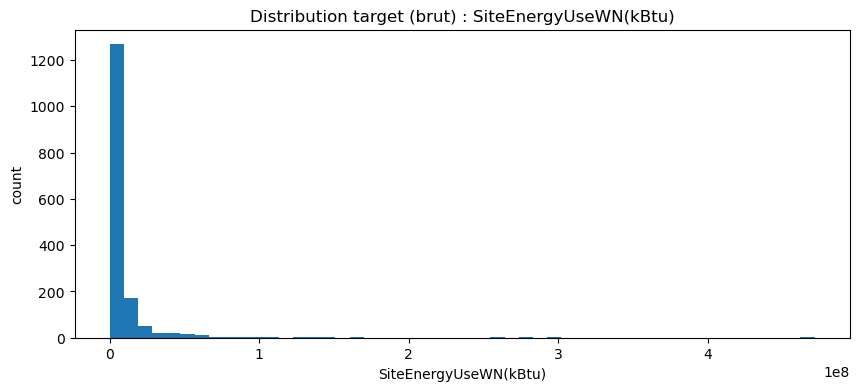

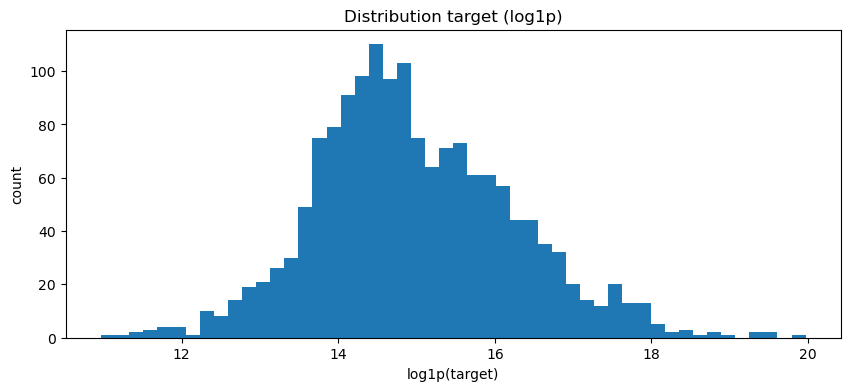

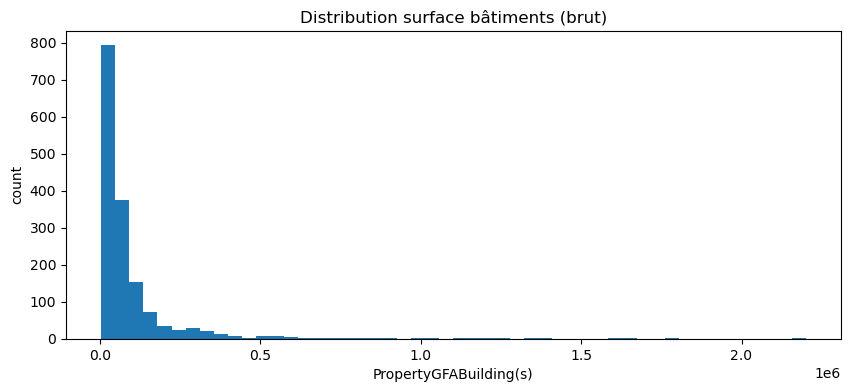

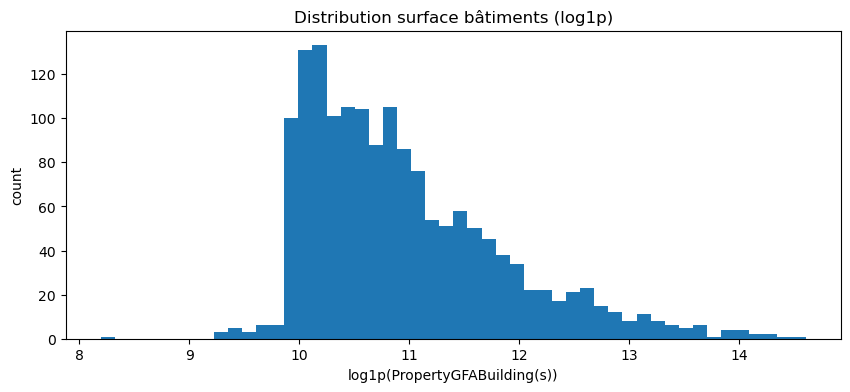

PrimaryPropertyType
Small- and Mid-Sized Office    286
Other                          236
Warehouse                      186
Large Office                   166
K-12 School                    123
Mixed Use Property             102
Retail Store                    89
Hotel                           74
Worship Facility                67
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  36
Self-Storage Facility           28
University                      21
Senior Care Community           20
Name: count, dtype: int64

In [304]:
plt.figure(figsize=(10,4))
plt.hist(df[TARGET], bins=50)
plt.title(f"Distribution target (brut) : {TARGET}")
plt.xlabel(TARGET); plt.ylabel("count")
plt.show()

plt.figure(figsize=(10,4))
plt.hist(df["log_target"], bins=50)
plt.title("Distribution target (log1p)")
plt.xlabel("log1p(target)"); plt.ylabel("count")
plt.show()

plt.figure(figsize=(10,4))
plt.hist(df[GFA_BUILD], bins=50)
plt.title("Distribution surface bâtiments (brut)")
plt.xlabel(GFA_BUILD); plt.ylabel("count")
plt.show()

plt.figure(figsize=(10,4))
plt.hist(df["log_gfa"], bins=50)
plt.title("Distribution surface bâtiments (log1p)")
plt.xlabel("log1p(PropertyGFABuilding(s))"); plt.ylabel("count")
plt.show()

df["PrimaryPropertyType"].value_counts().head(15)


- La target brute est fortement asymétrique : beaucoup de bâtiments ont une consommation faible/modérée, et quelques bâtiments très énergivores étirent la distribution. Une transformation log1p rend la distribution plus lisible et plus proche d’une forme gaussienne.
- La surface des bâtiments est également très asymétrique, ce qui justifie l’utilisation de log1p pour analyser la distribution.
- Les PrimaryPropertyType montrent une majorité de bureaux (small/mid + large), puis des catégories variées (warehouse, écoles…).

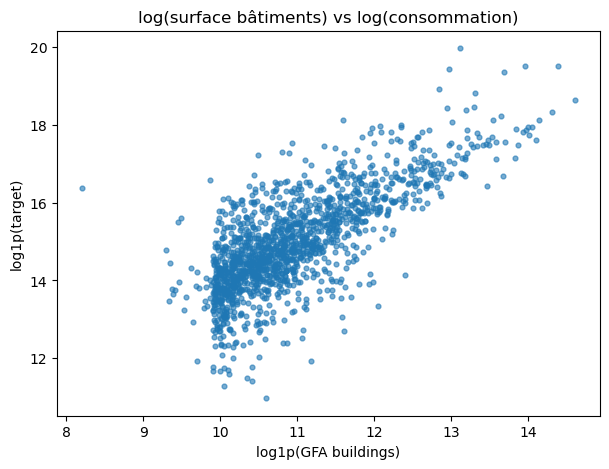

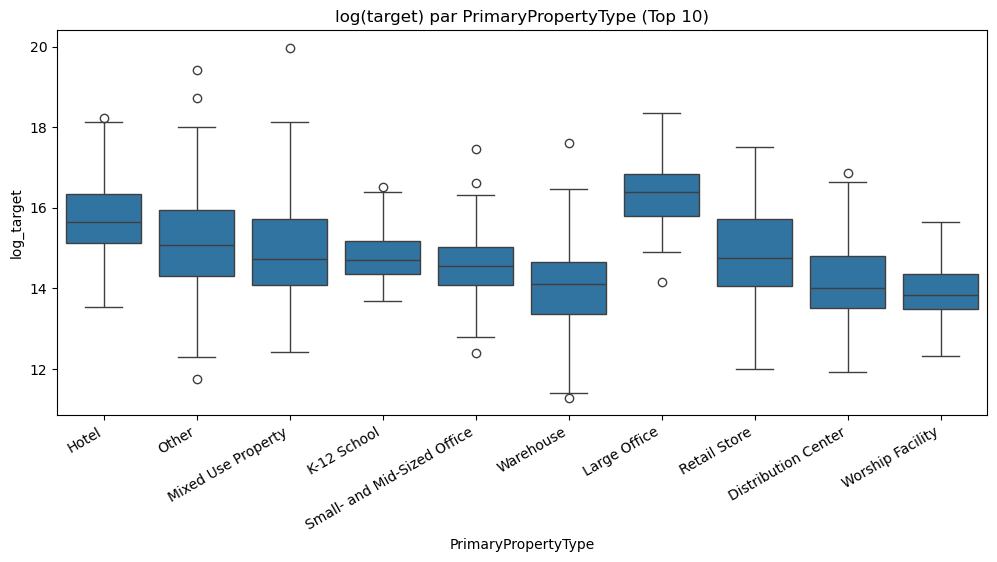

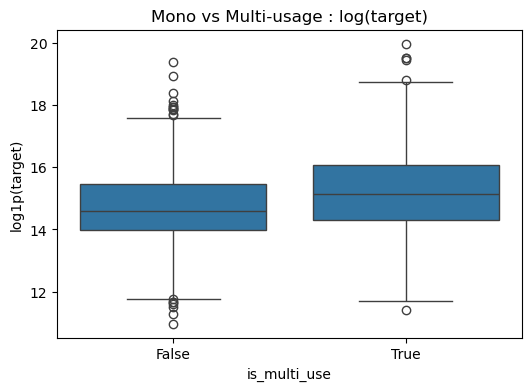

In [305]:
sample = df.sample(min(1500, len(df)), random_state=42)

plt.figure(figsize=(7,5))
plt.scatter(sample["log_gfa"], sample["log_target"], s=12, alpha=0.6)
plt.title("log(surface bâtiments) vs log(consommation)")
plt.xlabel("log1p(GFA buildings)")
plt.ylabel("log1p(target)")
plt.show()

top10 = df["PrimaryPropertyType"].value_counts().head(10).index
df_top10 = df[df["PrimaryPropertyType"].isin(top10)].copy()

plt.figure(figsize=(12,5))
sns.boxplot(data=df_top10, x="PrimaryPropertyType", y="log_target")
plt.xticks(rotation=30, ha="right")
plt.title("log(target) par PrimaryPropertyType (Top 10)")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="is_multi_use", y="log_target")
plt.title("Mono vs Multi-usage : log(target)")
plt.xlabel("is_multi_use"); plt.ylabel("log1p(target)")
plt.show()

- La consommation (log) est positivement corrélée à la surface (log), ce qui confirme que la taille est un déterminant majeur. La dispersion importante à surface égale indique que l’usage et d’autres caractéristiques expliquent une part significative de la variabilité.”
- La distribution de consommation varie fortement selon le type de bâtiment, ce qui confirme que PrimaryPropertyType est une variable explicative majeure. Certaines catégories sont très hétérogènes (Other, Mixed Use Property), suggérant des sous-usages variés.
- Les bâtiments multi-usages présentent une consommation (médiane) plus élevée et une dispersion plus importante que les mono-usages. La variable is_multi_use apporte donc une information pertinente à conserver pour la modélisation.

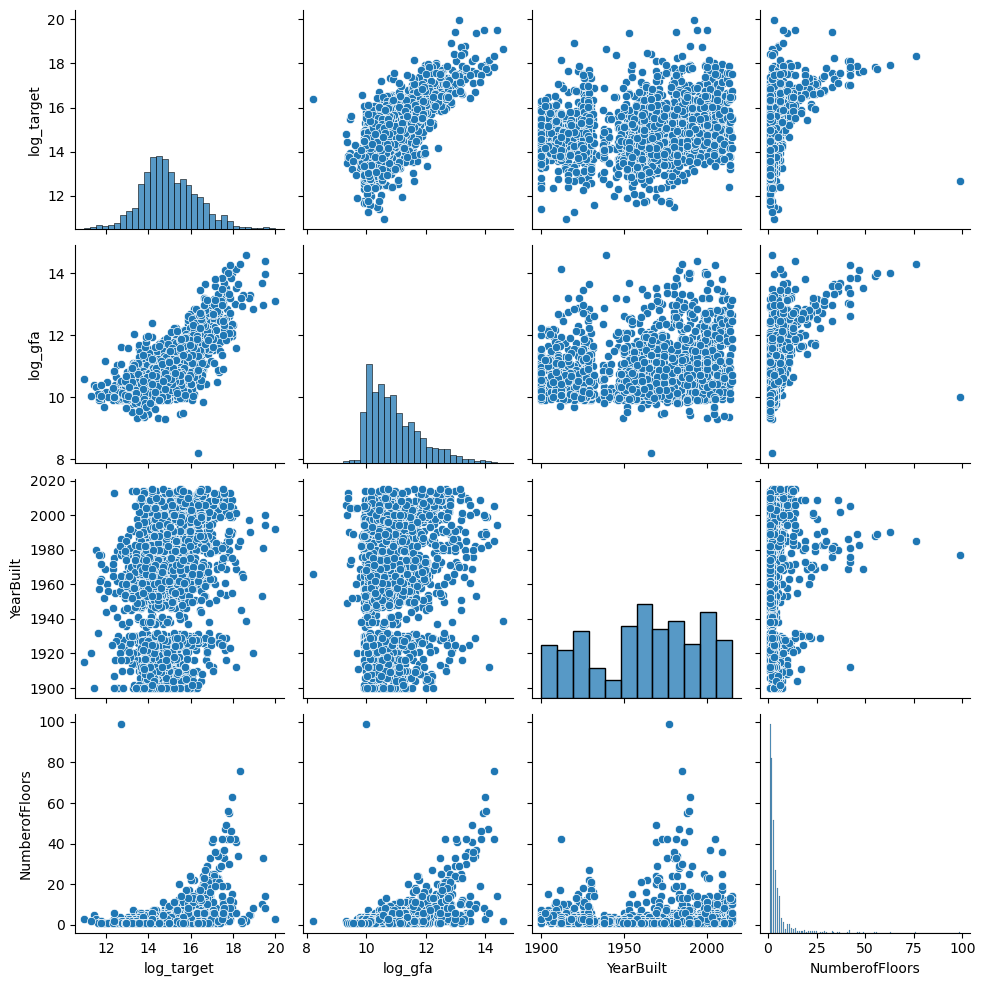

In [306]:
cols_pair = ["log_target", "log_gfa", "YearBuilt", "NumberofFloors"]
sns.pairplot(df[cols_pair].dropna())
plt.show()

Le pairplot confirme une relation positive entre la surface (log) et la consommation (log). La variable NumberofFloors montre une légère corrélation tandis que la variable YearBuilt ne montre pas de relation linéaire simple avec la consommation.

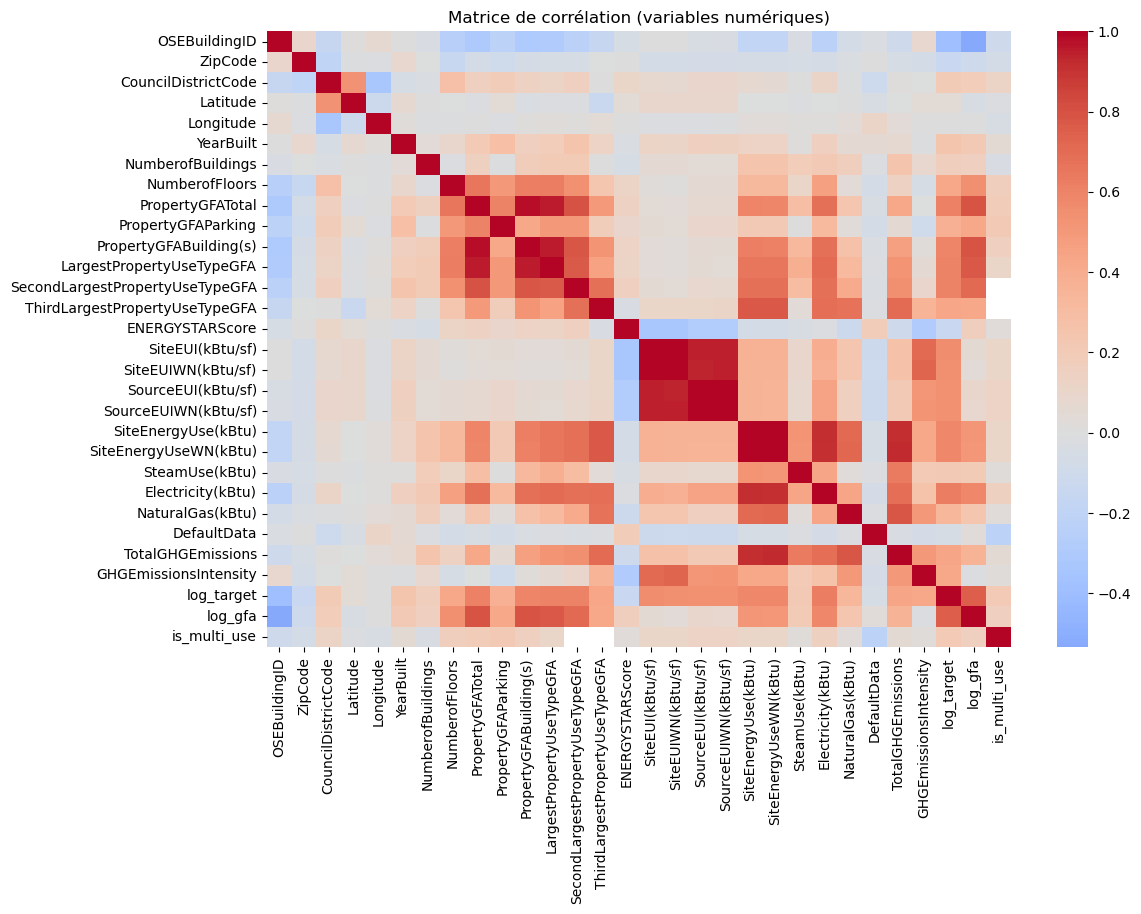

In [307]:
num_cols = df.select_dtypes(include=["int64","float64","bool"]).columns
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation (variables numériques)")
plt.show()

La matrice de corrélation met en évidence trois groupes de variables très corrélées : (1) les surfaces (GFA) qui décrivent la taille du bâtiment, (2) les indicateurs d’intensité énergétique (EUI) fortement redondants entre eux, et (3) les consommations par source (électricité/gaz/vapeur) fortement liées à la consommation totale. Ces observations permettent d’identifier des variables redondantes (à simplifier) et des variables susceptibles de provoquer une fuite de données si elles sont utilisées comme features pour prédire la consommation.

#### TERMINER L'ANALYSE EXPLORATOIRE 

A réaliser : 
- Une analyse descriptive des données, y compris une explication du sens des colonnes gardées, des arguments derrière la suppression de lignes ou de colonnes, des statistiques descriptives et des visualisations pertinentes.

Qelques pistes d'analyse : 

* Identifier les colonnes avec une majorité de valeurs manquantes ou constantes en utilisant la méthode value_counts() de Pandas
* Mettre en evidence les différences entre les immeubles mono et multi-usages
* Utiliser des pairplots et des boxplots pour faire ressortir les outliers ou des batiments avec des valeurs peu cohérentes d'un point de vue métier 

Pour vous inspirer, ou comprendre l'esprit recherché dans une analyse exploratoire, vous pouvez consulter ce notebook en ligne : https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python. Il ne s'agit pas d'un modèle à suivre à la lettre ni d'un template d'analyses attendues pour ce projet. 

# Modélisation 

### Import des modules 

In [308]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

En règle générale : On utilise la méthode .apply() de Pandas pour créer une nouvelle colonne à partir d'une colonne existante. N'hésitez pas à regarder les exemples dans les chapitres de cours donnés en ressource

In [309]:
# Temporel
REF_YEAR = 2016
# On calcule l'age du building
df["building_age"] = (REF_YEAR - df["YearBuilt"]).clip(lower=0)
# On regroupe les années de construction par décennie 
df["built_decade"] = df["YearBuilt"].apply(lambda y: int(y//10*10) if pd.notna(y) else np.nan)

df[["YearBuilt", "building_age", "built_decade"]].head()

,YearBuilt,building_age,built_decade
0,1927,89,1920
1,1996,20,1990
2,1969,47,1960
3,1926,90,1920
4,1980,36,1980


In [310]:
# Structrel

# On calcule la surface par étage
df["gfa_per_floor"] = df[GFA_BUILD] / df["NumberofFloors"]
# On calcule le ratio du parking par rapport à la surface du building
if "PropertyGFAParking" in df.columns:
    df["parking_ratio"] = (df["PropertyGFAParking"] / df[GFA_BUILD]).clip(0, 5)

check_cols = ["gfa_per_floor"] + [c for c in ["parking_ratio"] if c in df.columns]
df[check_cols].describe()

,gfa_per_floor,parking_ratio
count,1.574000e+03,1574.000000
mean,3.208534e+04,0.113928
std,4.760043e+04,0.358273
min,2.216970e+02,0.000000
25%,1.269042e+04,0.000000
50%,2.121475e+04,0.000000
75%,3.401164e+04,0.000000
max,1.100000e+06,5.000000


In [311]:
# Multi usage

# On calcule la proportion de l'ultilisation principale
if "LargestPropertyUseTypeGFA" in df.columns:
    df["largest_use_share"] = (df["LargestPropertyUseTypeGFA"] / df[GFA_BUILD]).clip(0, 1.5)
# On calcule la proportion de l'ultilisation secondaire
if "SecondLargestPropertyUseTypeGFA" in df.columns:
    df["second_use_share"] = (df["SecondLargestPropertyUseTypeGFA"].fillna(0) / df[GFA_BUILD]).clip(0, 1.5)

check_cols = ["is_multi_use"] + [c for c in ["largest_use_share", "second_use_share"] if c in df.columns]
df[check_cols].describe(include="all")

,is_multi_use,largest_use_share,second_use_share
count,1574,1570.000000,1574.000000
unique,2,NaN,NaN
top,True,NaN,NaN
freq,817,NaN,NaN
mean,NaN,0.920171,0.146964
std,NaN,0.226250,0.213249
min,NaN,0.186469,0.000000
25%,NaN,0.812868,0.000000
50%,NaN,1.000000,0.000000
75%,NaN,1.000000,0.258902


In [312]:
# Localisation

# On regroupe les latitudes
if "Latitude" in df.columns:
    df["lat_bin"] = pd.qcut(df["Latitude"], q=5, labels=False, duplicates="drop")
# On regroupe les longitudes
if "Longitude" in df.columns:
    df["lon_bin"] = pd.qcut(df["Longitude"], q=5, labels=False, duplicates="drop")

[c for c in ["lat_bin","lon_bin"] if c in df.columns], df[[c for c in ["lat_bin","lon_bin"] if c in df.columns]].head()

(['lat_bin', 'lon_bin'],
    lat_bin  lon_bin
 0        2        1
 1        2        2
 2        2        1
 3        2        1
 4        2        1)

In [313]:
# Énergetique

# On indique quel type d'énergie est présent
if "NaturalGas(kBtu)" in df.columns:
    df["has_gas"] = (df["NaturalGas(kBtu)"] > 0).astype(int)

if "SteamUse(kBtu)" in df.columns:
    df["has_steam"] = (df["SteamUse(kBtu)"] > 0).astype(int)

if "Electricity(kBtu)" in df.columns:
    df["has_electricity"] = (df["Electricity(kBtu)"] > 0).astype(int)

src_cols = [c for c in ["has_gas","has_steam","has_electricity"] if c in df.columns]
if src_cols:
    df["energy_sources_count"] = df[src_cols].sum(axis=1)

src_cols = [c for c in ["has_gas","has_steam","has_electricity","energy_sources_count"] if c in df.columns]
df[src_cols].value_counts().head(10) if src_cols else "Pas de colonnes énergie disponibles"

has_gas  has_steam  has_electricity  energy_sources_count
1        0          1                2                       1074
0        0          1                1                        390
1        1          1                3                         62
0        1          1                2                         45
         0          0                0                          2
1        0          0                1                          1
Name: count, dtype: int64

In [314]:
# Récap des nouvelles features

new_features = [
    "building_age", "built_decade",
    "gfa_per_floor", "parking_ratio",
    "is_multi_use", "largest_use_share", "second_use_share",
    "lat_bin", "lon_bin",
    "has_gas", "has_steam", "has_electricity", "energy_sources_count"
]
new_features = [c for c in new_features if c in df.columns]

print("Nouvelles features créées:", new_features)
df[new_features].isna().mean().sort_values(ascending=False).head(10)

Nouvelles features créées: ['building_age', 'built_decade', 'gfa_per_floor', 'parking_ratio', 'is_multi_use', 'largest_use_share', 'second_use_share', 'lat_bin', 'lon_bin', 'has_gas', 'has_steam', 'has_electricity', 'energy_sources_count']


largest_use_share    0.002541
built_decade         0.000000
gfa_per_floor        0.000000
parking_ratio        0.000000
building_age         0.000000
is_multi_use         0.000000
second_use_share     0.000000
lat_bin              0.000000
lon_bin              0.000000
has_gas              0.000000
dtype: float64

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn 
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne. Les deux méthodes d'encodage à connaitre sont le OneHotEncoder et le LabelEncoder

In [315]:
# CODE PREPARATION DES FEATURES

df_model = df.copy()
print("Shape départ:", df_model.shape)

Shape départ: (1574, 54)


In [316]:
# On drop les colonnes ID ou texte inutile
cols_drop_id_text = [
    "OSEBuildingID", "TaxParcelIdentificationNumber",
    "PropertyName", "Address"
]
cols_drop_id_text = [c for c in cols_drop_id_text if c in df_model.columns]
print("Drop ID/texte:", cols_drop_id_text)

df_model = df_model.drop(columns=cols_drop_id_text)
print("Shape après drop ID/texte:", df_model.shape)

Drop ID/texte: ['OSEBuildingID', 'TaxParcelIdentificationNumber', 'PropertyName', 'Address']
Shape après drop ID/texte: (1574, 50)


In [317]:
# On drop les colonnes inutiles
cols_drop_useless = [
    "Outlier", "ComplianceStatus",
    "ListOfAllPropertyUseTypes",
    "ZipCode", "DefaultData"
]
cols_drop_useless = [c for c in cols_drop_useless if c in df_model.columns]
print("Drop useless:", cols_drop_useless)

df_model = df_model.drop(columns=cols_drop_useless)
print("Shape après drop useless:", df_model.shape)

Drop useless: ['Outlier', 'ComplianceStatus', 'ListOfAllPropertyUseTypes', 'ZipCode', 'DefaultData']
Shape après drop useless: (1574, 45)


In [318]:
# On drop les colonnes qui provoqueraient du data leakage
cols_drop_leak = [
    # autre version de l'énergie totale
    "SiteEnergyUse(kBtu)",
    # EUI (dérivé de la conso / surface)
    "SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)",
    "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)",
    # quantités énergie par source (fuite)
    "Electricity(kBtu)", "NaturalGas(kBtu)", "SteamUse(kBtu)",
    # émissions/score (souvent dérivés)
    "TotalGHGEmissions", "GHGEmissionsIntensity", "ENERGYSTARScore",
    # colonnes de confort EDA
    "log_target", "log_gfa"
]
cols_drop_leak = [c for c in cols_drop_leak if c in df_model.columns]
print("Drop leak:", cols_drop_leak)

df_model = df_model.drop(columns=cols_drop_leak)
print("Shape après drop leak:", df_model.shape)

Drop leak: ['SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'ENERGYSTARScore', 'log_target', 'log_gfa']
Shape après drop leak: (1574, 32)


In [319]:
# On filtre les outliers en utilisants la méthode des quantiles (on suppr les 0,5% qui consomment le moins et 0,5% qui consomment le plus)
q_low, q_high = df[TARGET].quantile([0.005, 0.995])
print("Quantiles target:", q_low, q_high)

mask = (df[TARGET] >= q_low) & (df[TARGET] <= q_high)

before = df_model.shape[0]
df_model = df_model.loc[mask].copy()

print(f"Outliers target supprimés (quantiles): {before} -> {df_model.shape[0]} (supprimés {before-df_model.shape[0]})")

Quantiles target: 126460.9275 125082134.51999988
Outliers target supprimés (quantiles): 1574 -> 1558 (supprimés 16)


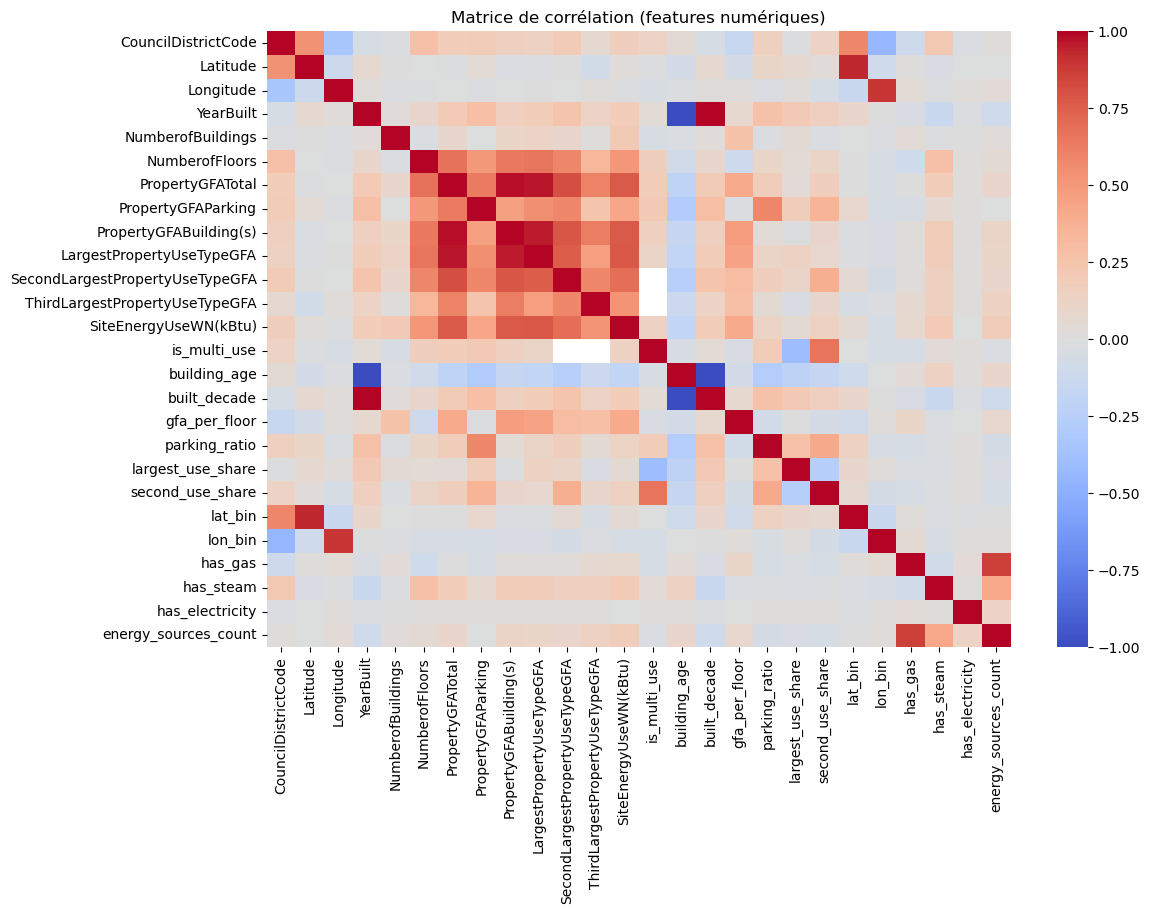

In [320]:
# On crée une matrice de corrélation avec les variables numériques pour évaluer la redondanc
num_cols = df_model.select_dtypes(include=["int64", "float64", "bool"]).columns
corr = df_model[num_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation (features numériques)")
plt.show()

In [321]:
## On examine la corrélation entre certaines paires de features
corr_abs = corr.abs()

# On créé une matrice de 1, on garde uniquement le triangle supérieur True/False (sans la diagonale) 
mask_corr = np.triu(np.ones_like(corr_abs, dtype=bool), k=1)
# On applique le mask et stocke les valeurs qui avaient True
upper = corr_abs.where(mask_corr)
high_pairs = upper.stack().sort_values(ascending=False)

high_pairs[high_pairs > 0.70].head(20)

YearBuilt                  building_age                       1.000000
building_age               built_decade                       0.995413
YearBuilt                  built_decade                       0.995413
PropertyGFATotal           PropertyGFABuilding(s)             0.977791
                           LargestPropertyUseTypeGFA          0.963171
PropertyGFABuilding(s)     LargestPropertyUseTypeGFA          0.958738
Latitude                   lat_bin                            0.936821
Longitude                  lon_bin                            0.897041
has_gas                    energy_sources_count               0.860306
PropertyGFATotal           SecondLargestPropertyUseTypeGFA    0.819270
PropertyGFABuilding(s)     SecondLargestPropertyUseTypeGFA    0.786030
LargestPropertyUseTypeGFA  SiteEnergyUseWN(kBtu)              0.773636
PropertyGFATotal           SiteEnergyUseWN(kBtu)              0.768336
PropertyGFABuilding(s)     SiteEnergyUseWN(kBtu)              0.766749
Larges

In [322]:
# On drop les colonnes trop redondantes

to_drop_redundant = [
    "YearBuilt",
    "built_decade",
    "PropertyGFATotal",
    "LargestPropertyUseTypeGFA",
    "lat_bin", "lon_bin",
    "energy_sources_count"]
if "PropertyGFATotal" in df_model.columns and "PropertyGFABuilding(s)" in df_model.columns:
    to_drop_redundant.append("PropertyGFATotal")

df_model = df_model.drop(columns=[c for c in to_drop_redundant if c in df_model.columns])
print("Redondances droppées:", to_drop_redundant)
print("Shape après redondances:", df_model.shape)

Redondances droppées: ['YearBuilt', 'built_decade', 'PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'lat_bin', 'lon_bin', 'energy_sources_count', 'PropertyGFATotal']
Shape après redondances: (1558, 25)


In [323]:
# On sépare X et y
y = df_model[TARGET].copy()
X = df_model.drop(columns=[TARGET]).copy()

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1558, 24)
y shape: (1558,)


In [324]:
# On sépare les variables numériques et catégorielles (qu'on va encoder juste après)
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64","float64","bool"]).columns.tolist()

print("Cat cols:", cat_cols)
print("Num cols:", num_cols[:10], "...")

Cat cols: ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
Num cols: ['CouncilDistrictCode', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'is_multi_use'] ...


In [325]:
# Fill NA dans catégorielles
for c in cat_cols:
    X[c] = X[c].fillna("Unknown")

In [326]:
# On défini le preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", max_categories=30), cat_cols),
    ],
    remainder="drop"
)

preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['CouncilDistrictCode', 'Latitude',
                                  'Longitude', 'NumberofBuildings',
                                  'NumberofFloors', 'PropertyGFAParking',
                                  'PropertyGFABuilding(s)',
                                  'SecondLargestPropertyUseTypeGFA',
                                  'ThirdLargestPropertyUseTypeGFA',
                                  'is_multi_use', 'building_age',
                                  'gfa_per_floor', 'parking_ratio',
                                  'largest_use_share', 'second_use_share',
                                  'has_gas', 'has_steam', 'has_electricity']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               max_categories=30),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'Neighborhood', 'LargestPropertyUseType',
                                  'SecondLargestPropertyUseType',
                                  'ThirdLargestPropertyUseType'])])

In [327]:
# On split train/test le jeu de données 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1246, 24) (312, 24) (1246,) (312,)


In [328]:
# On règle les paramètres du preprocessor et on l'applique sur train puis on l'applique sur test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print(X_train_prep.shape, X_test_prep.shape)

(1246, 152) (312, 152)


### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

In [329]:
# CODE COMPARAISON DES MODELES

### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn.

In [330]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE